# To Do

Stuff to look into
- Can I remove the pre-scaling? Maybe don't need it now that I am scaling in pipeline
- Can I remove the train / dev split? Only place I really need it is in the grid search cv, which I pass indices and full frame
- 

# Prompt

## Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

## The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals.  

From the dataset documentation [here](https://www.openml.org/d/534):

> The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership.

## Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

# Imports

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
    make_column_selector,
)
from sklearn.utils import Bunch
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

from IPython.display import Image

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [3]:
df = fetch_openml(data_id=534, as_frame=True).frame

In [4]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [5]:
df.describe()

,EDUCATION,EXPERIENCE,WAGE,AGE
count,534.000000,534.000000,534.000000,534.000000
mean,13.018727,17.822097,9.024064,36.833333
std,2.615373,12.379710,5.139097,11.726573
min,2.000000,0.000000,1.000000,18.000000
25%,12.000000,8.000000,5.250000,28.000000
50%,12.000000,15.000000,7.780000,35.000000
75%,15.000000,26.000000,11.250000,44.000000
max,18.000000,55.000000,44.500000,64.000000


In [6]:
df = df.query("WAGE > 1 and WAGE < 30")

In [7]:
df.describe()

,EDUCATION,EXPERIENCE,WAGE,AGE
count,532.000000,532.000000,532.000000,532.000000
mean,13.018797,17.842105,8.972462,36.853383
std,2.619574,12.378581,4.900585,11.726366
min,2.000000,0.000000,1.750000,18.000000
25%,12.000000,8.000000,5.250000,28.000000
50%,12.000000,15.000000,7.780000,35.000000
75%,15.000000,26.000000,11.250000,44.000000
max,18.000000,55.000000,26.290000,64.000000


In [8]:
df.loc[:, df.dtypes == "category"].nunique()

SOUTH         2
SEX           2
UNION         2
RACE          3
OCCUPATION    6
SECTOR        3
MARR          2
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   532 non-null    int64   
 1   SOUTH       532 non-null    category
 2   SEX         532 non-null    category
 3   EXPERIENCE  532 non-null    int64   
 4   UNION       532 non-null    category
 5   WAGE        532 non-null    float64 
 6   AGE         532 non-null    int64   
 7   RACE        532 non-null    category
 8   OCCUPATION  532 non-null    category
 9   SECTOR      532 non-null    category
 10  MARR        532 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 25.4 KB


# Model Prep

## Feature and Frame Naming

### Features

In [10]:
target_feature = "WAGE"
numeric_features = df.columns[df.dtypes != "category"].to_list()
numeric_features.remove(target_feature)
one_hot_features = df.columns[df.dtypes == "category"].to_list()
display([numeric_features, one_hot_features])

[['EDUCATION', 'EXPERIENCE', 'AGE'],
 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]

### Prefix Feature Type For Clarity in Understanding Importance

In [11]:
numeric_features_prefix = ["numeric_" + name for name in numeric_features]
one_hot_features_prefix = ["category_" + name for name in one_hot_features]
df = df.rename(columns=dict(zip(one_hot_features, one_hot_features_prefix))).rename(
    columns=dict(zip(numeric_features, numeric_features_prefix))
)

numeric_features = numeric_features_prefix
one_hot_features = one_hot_features_prefix

In [12]:
df.head()

,numeric_EDUCATION,category_SOUTH,category_SEX,numeric_EXPERIENCE,category_UNION,WAGE,numeric_AGE,category_RACE,category_OCCUPATION,category_SECTOR,category_MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


### Frames

In [13]:
X = df.drop(columns=target_feature)
y = df[target_feature]

<Axes: >

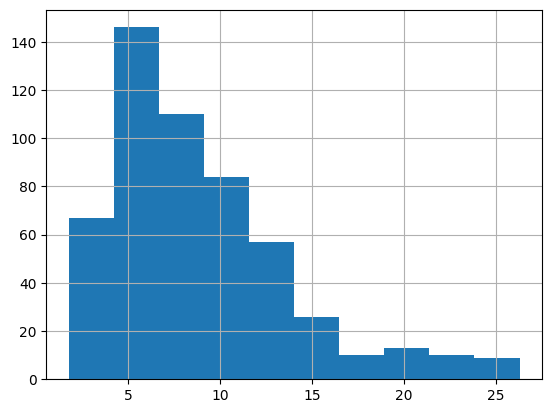

In [14]:
y.hist()

## Train & Development Split

In [15]:
X[numeric_features] = StandardScaler().fit_transform(X[numeric_features])
# X.describe()

In [16]:
(X_train, X_dev, y_train, y_dev, train_inds, dev_inds) = train_test_split(
    X, y, range(len(df)), random_state=42, train_size=0.75
)

X_train.head()

,numeric_EDUCATION,category_SOUTH,category_SEX,numeric_EXPERIENCE,category_UNION,numeric_AGE,category_RACE,category_OCCUPATION,category_SECTOR,category_MARR
509,1.139120,no,female,0.336210,member,0.610022,White,Professional,Other,Married
196,1.139120,no,female,0.659653,not_member,0.951455,White,Management,Other,Married
419,-0.389283,no,female,-0.634118,not_member,-0.755709,White,Service,Other,Unmarried
19,-0.389283,no,male,1.225679,not_member,1.207529,White,Other,Other,Married
390,-0.389283,no,female,0.740514,not_member,0.695380,White,Service,Other,Married


# Pipeline Definition

Make a pipeline with the following steps:
- Column Transformer
    - Polynomial Features
    - One hot encoder
- Ridge regression

## Column Transformer

In [17]:
xformer = make_column_transformer(
    (
        PolynomialFeatures(include_bias=False),
        numeric_features,
    ),
    (
        OneHotEncoder(drop="if_binary"),
        one_hot_features,
    ),
)

In [18]:
xformer.fit(X, y)
pd.DataFrame(xformer.transform(X), columns=xformer.get_feature_names_out())

,polynomialfeatures__numeric_EDUCATION,polynomialfeatures__numeric_EXPERIENCE,polynomialfeatures__numeric_AGE,polynomialfeatures__numeric_EDUCATION^2,polynomialfeatures__numeric_EDUCATION numeric_EXPERIENCE,polynomialfeatures__numeric_EDUCATION numeric_AGE,polynomialfeatures__numeric_EXPERIENCE^2,polynomialfeatures__numeric_EXPERIENCE numeric_AGE,polynomialfeatures__numeric_AGE^2,onehotencoder__category_SOUTH_yes,onehotencoder__category_SEX_male,onehotencoder__category_UNION_not_member,onehotencoder__category_RACE_Hispanic,onehotencoder__category_RACE_Other,onehotencoder__category_RACE_White,onehotencoder__category_OCCUPATION_Clerical,onehotencoder__category_OCCUPATION_Management,onehotencoder__category_OCCUPATION_Other,onehotencoder__category_OCCUPATION_Professional,onehotencoder__category_OCCUPATION_Sales,onehotencoder__category_OCCUPATION_Service,onehotencoder__category_SECTOR_Construction,onehotencoder__category_SECTOR_Manufacturing,onehotencoder__category_SECTOR_Other,onehotencoder__category_MARR_Unmarried
0,-1.917686,0.255350,-0.158201,3.677519,-0.489681,0.303381,0.065203,-0.040397,0.025028,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.535585,1.953425,1.719678,2.358022,-2.999651,-2.640713,3.815870,3.359263,2.957294,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.389283,-1.361865,-1.523932,0.151541,0.530151,0.593241,1.854676,2.075390,2.322369,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.389283,-1.119283,-1.267858,0.151541,0.435718,0.493556,1.252794,1.419091,1.607463,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,-0.389283,-0.068093,-0.158201,0.151541,0.026508,0.061585,0.004637,0.010772,0.025028,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,1.903321,-1.038422,-0.670350,3.622631,-1.976451,-1.275892,1.078320,0.696107,0.449370,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
528,-0.389283,1.225679,1.207529,0.151541,-0.477136,-0.470071,1.502288,1.480043,1.458127,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
529,1.521220,0.578793,0.951455,2.314112,0.880471,1.447373,0.335001,0.550695,0.905266,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
530,-0.389283,-0.391536,-0.499634,0.151541,0.152418,0.194499,0.153301,0.195625,0.249634,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Pipeline

In [19]:
processing_pipe = Pipeline(
    [
        ("transformer", xformer),
        ("scaler", StandardScaler()),
        ("regression", Ridge(fit_intercept=True)),
    ]
)

processing_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['numeric_EDUCATION',
                                                   'numeric_EXPERIENCE',
                                                   'numeric_AGE']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['category_SOUTH',
                                                   'category_SEX',
                                                   'category_UNION',
                                                   'category_RACE',
                                                   'category_OCCUPATION',
                                                   'category_SECTOR',
                                                   'category_MARR'])])),
                ('scaler', StandardScaler()), ('regression', Ridge())])

In [20]:
regression_pipe = Pipeline(
    [
        (
            "ttr",
            TransformedTargetRegressor(
                regressor=processing_pipe, func=np.log, inverse_func=np.exp
            ),
        )
    ]
).fit(X_train, y_train)

regression_pipe

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('transformer',
                                                                       ColumnTransformer(transformers=[('polynomialfeatures',
                                                                                                        PolynomialFeatures(include_bias=False),
                                                                                                        ['numeric_EDUCATION',
                                                                                                         'numeric_EXPERIENCE',
                                                                                                         'numeric_AGE']),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='if_binary'),
                                                                                                        ['category_SOUTH',
                                                                                                         'category_SEX',
                                                                                                         'category_UNION',
                                                                                                         'category_RACE',
                                                                                                         'category_OCCUPATION',
                                                                                                         'category_SECTOR',
                                                                                                         'category_MARR'])])),
                                                                      ('scaler',
                                                                       StandardScaler()),
                                                                      ('regression',
                                                                       Ridge())])))])

# Grid Search for Polynomial Degree and Alpha

## Search Space Definition

In [21]:
alpha_list = 10 ** np.linspace(-5, 5, 51)
degree_list = range(1, 4)
param_grid = {
    "ttr__regressor__regression__alpha": alpha_list,
    "ttr__regressor__transformer__polynomialfeatures__degree": degree_list,
}
# param_grid

## Run the Search

In [22]:
grid_search = GridSearchCV(
    estimator=regression_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(X, y)

## Get the Best Model

In [23]:
grid_search.best_params_[list(grid_search.best_params_.keys())[0]]

158.48931924611142

In [24]:
best_alpha = grid_search.best_params_[list(grid_search.best_params_.keys())[0]]
best_poly_degree = grid_search.best_params_[list(grid_search.best_params_.keys())[1]]

In [25]:
regression_pipe_best = grid_search.best_estimator_.fit(X_train, y_train)
regression_pipe_best

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('transformer',
                                                                       ColumnTransformer(transformers=[('polynomialfeatures',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False),
                                                                                                        ['numeric_EDUCATION',
                                                                                                         'numeric_EXPERIENCE',
                                                                                                         'numeric_AGE']),
                                                                                                       ('onehotencoder',
                                                                                                        OneHotEncoder(drop='if_binary'),
                                                                                                        ['category_SOUTH',
                                                                                                         'category_SEX',
                                                                                                         'category_UNION',
                                                                                                         'category_RACE',
                                                                                                         'category_OCCUPATION',
                                                                                                         'category_SECTOR',
                                                                                                         'category_MARR'])])),
                                                                      ('scaler',
                                                                       StandardScaler()),
                                                                      ('regression',
                                                                       Ridge(alpha=158.48931924611142))])))])

## Plot Scores vs. Hyperparameter Grid

In [26]:
results_df = pd.DataFrame(grid_search.cv_results_["params"]).join(
    pd.DataFrame({"mean_test_score": grid_search.cv_results_["mean_test_score"]})
)

results_df.columns = [name.split("__")[-1] for name in results_df.columns]
# results_df

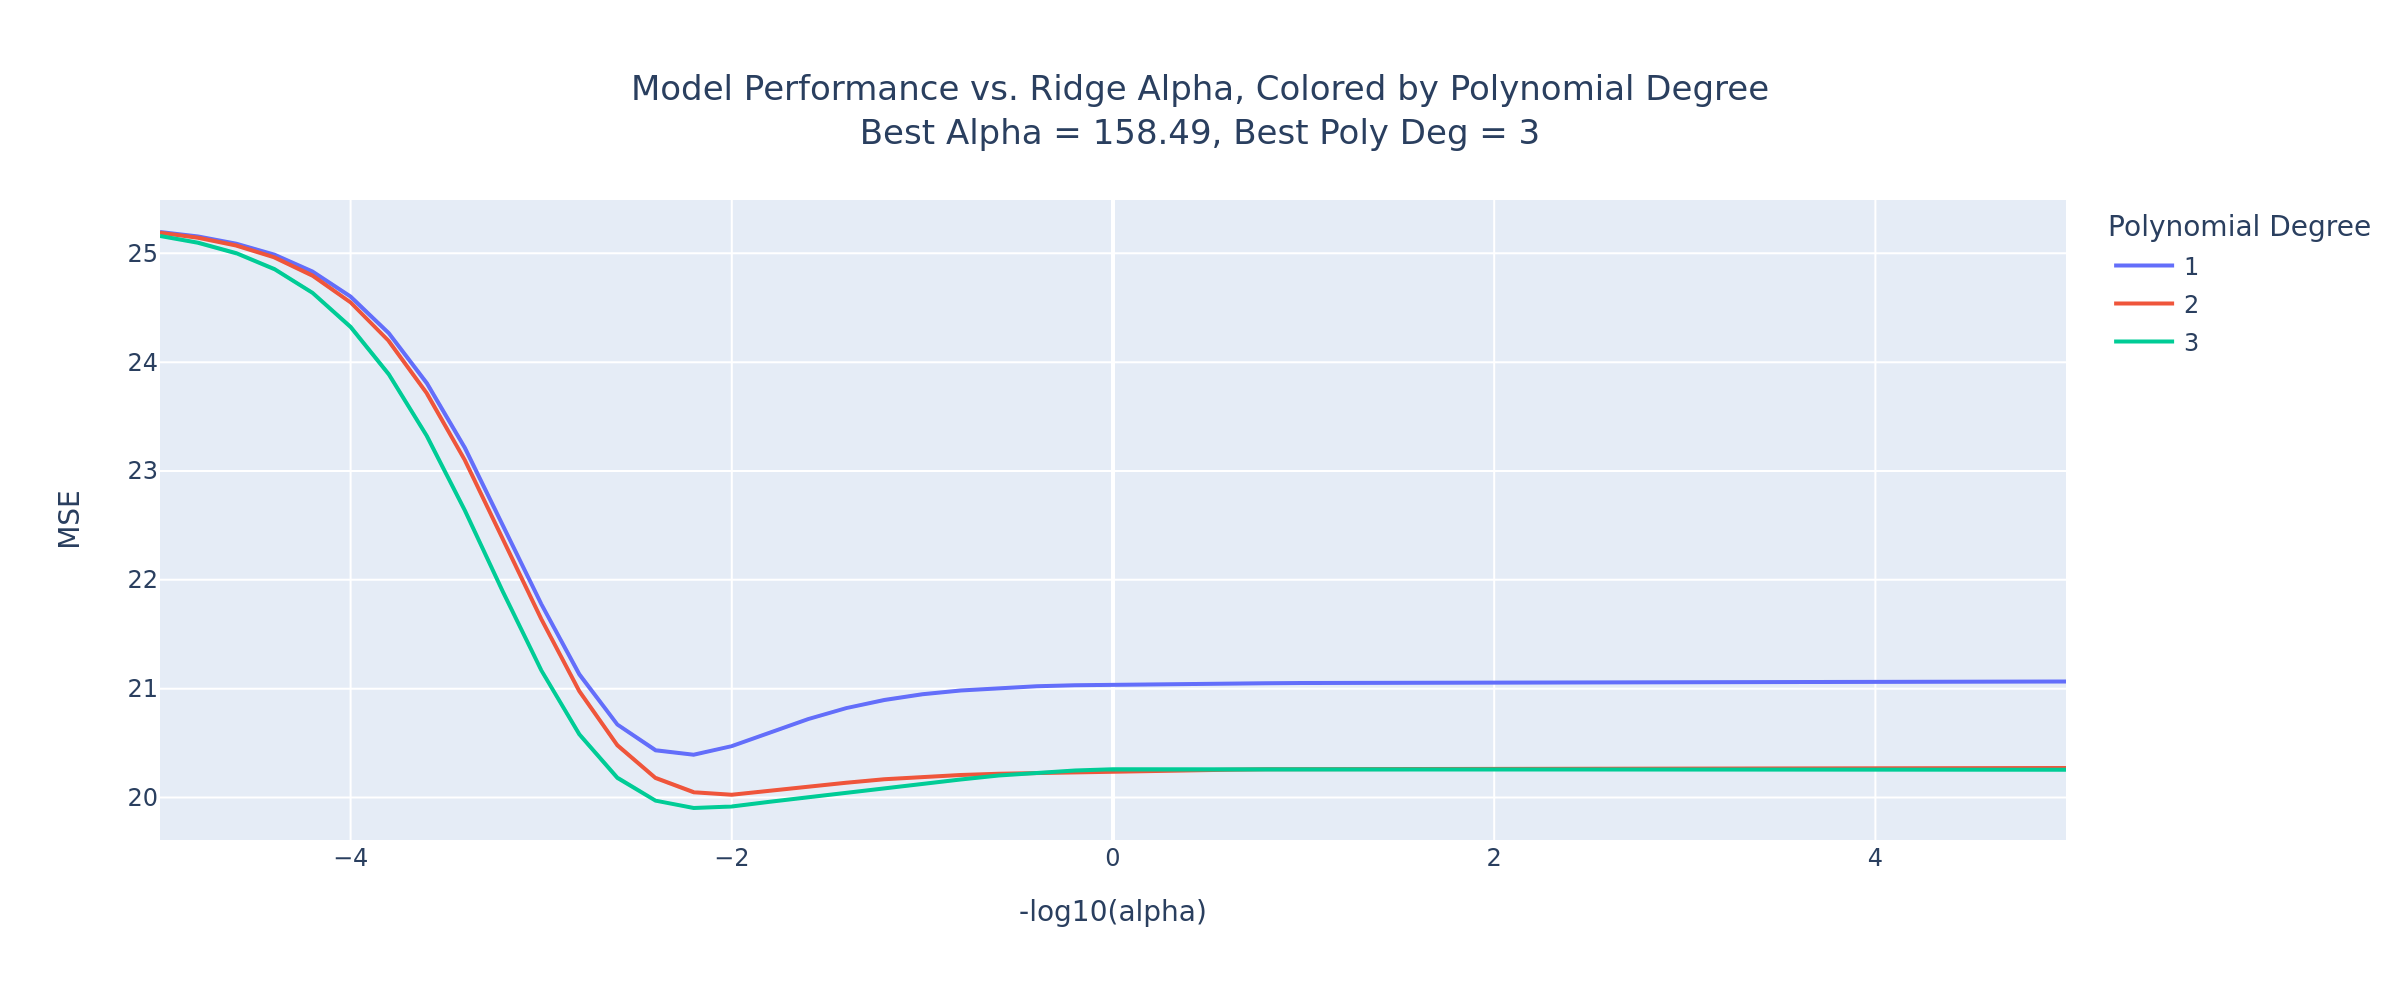

In [27]:
fig = px.line(
    results_df,
    x=-np.log10(results_df["alpha"]),
    y=-results_df["mean_test_score"],
    labels={
        "x": "-log10(alpha)",
        "y": "MSE",
        "degree": "Polynomial Degree",
    },
    title="Model Performance vs. Ridge Alpha, Colored by Polynomial Degree<br>Best Alpha = %.2f, Best Poly Deg = %d"
    % (best_alpha, best_poly_degree),
    color="degree",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

# Compare Basic to Best Pipeline

## Compute Predictions and Errors

In [28]:
y_train_pred = regression_pipe.predict(X_train)
y_train_pred_best = regression_pipe_best.predict(X_train)

In [29]:
dev_mse_basic = mean_squared_error(regression_pipe.predict(X_dev), y_dev)
dev_mse_best = mean_squared_error(regression_pipe_best.predict(X_dev), y_dev)
[dev_mse_basic, dev_mse_best]

[20.239302497602285, 19.903121518649336]

## Scatter with Basic and Best Estimators

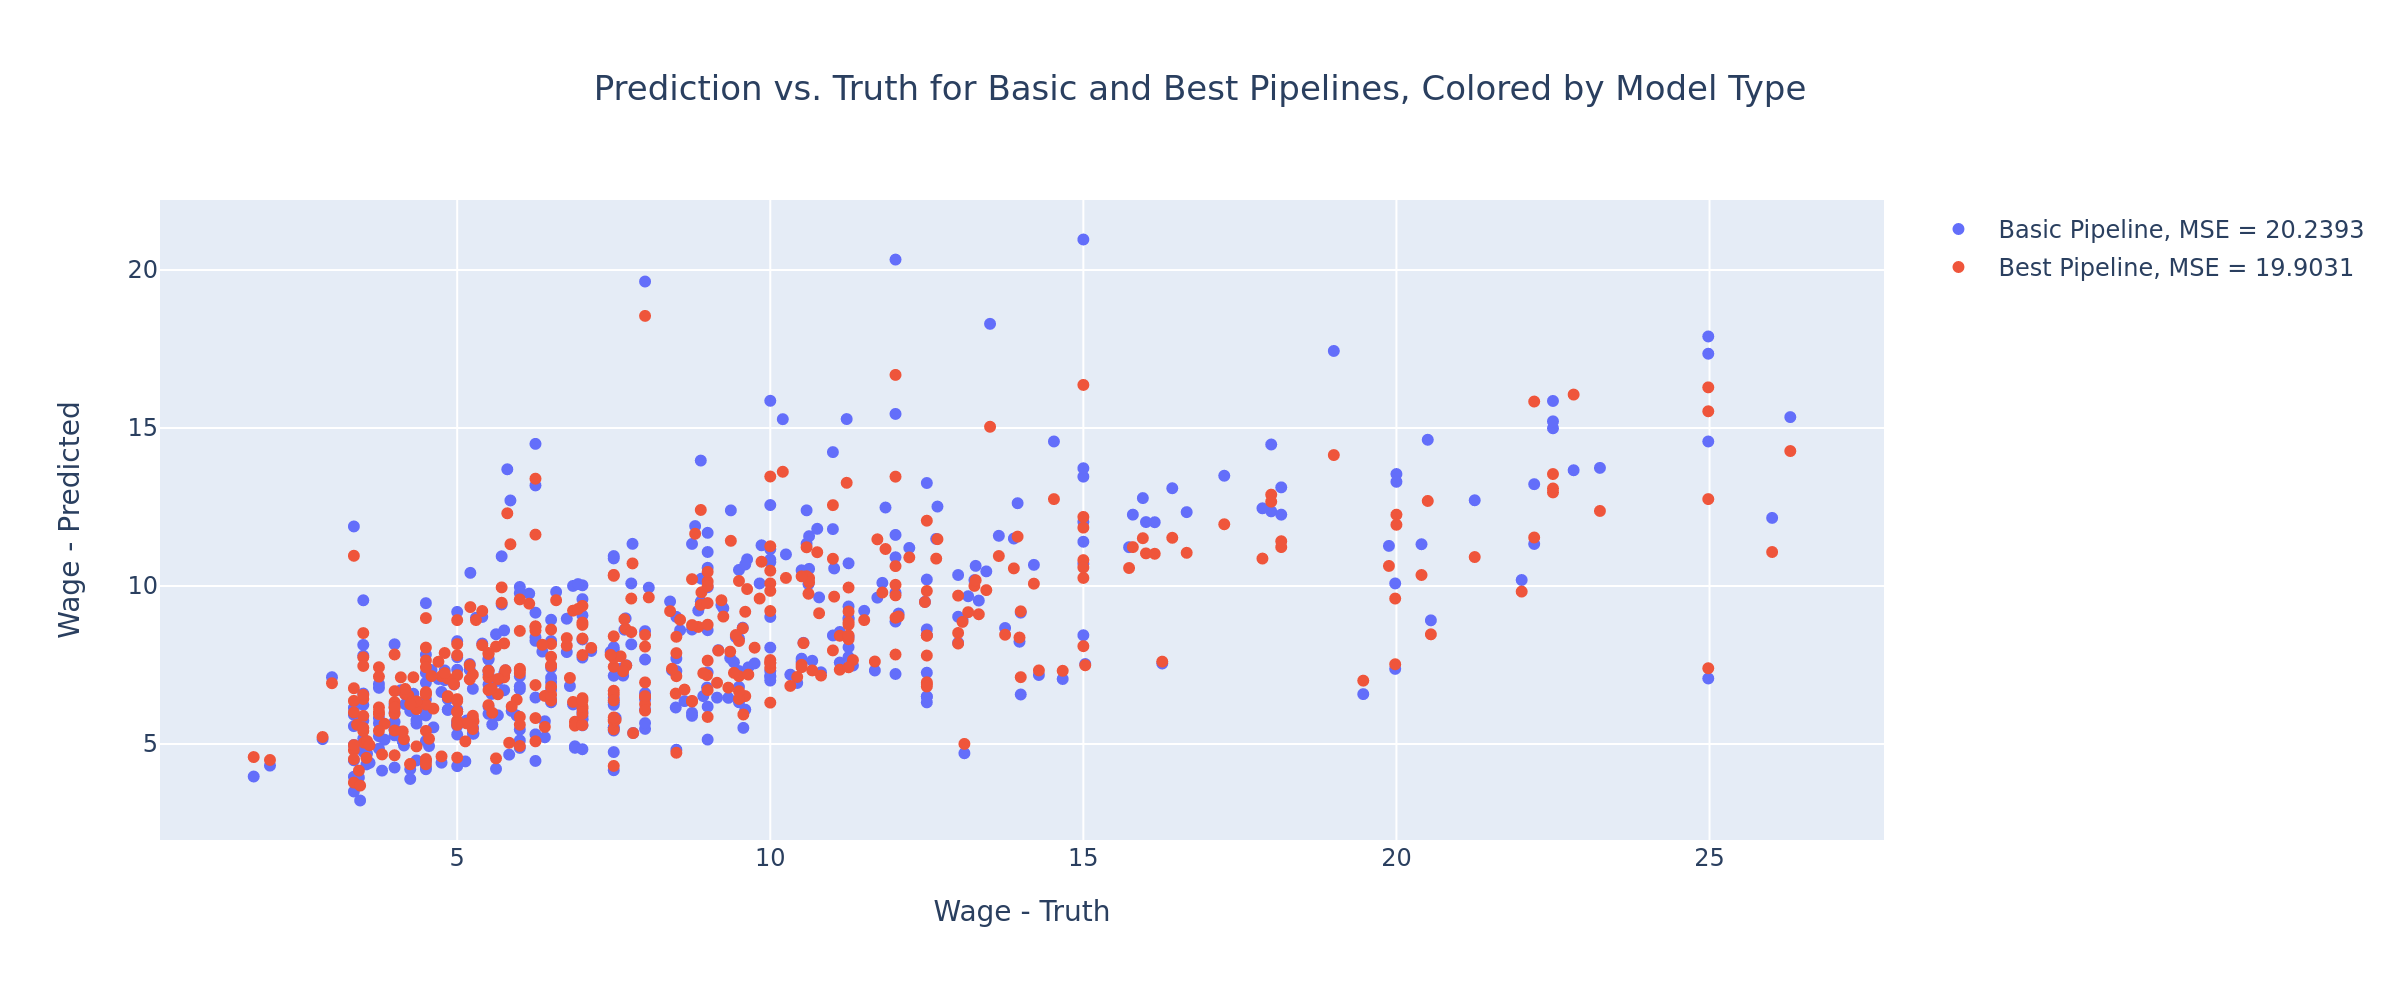

In [30]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y_train,
        y=y_train_pred,
        mode="markers",
        name="Basic Pipeline, MSE = %.4f" % dev_mse_basic,
    )
)

fig.add_trace(
    go.Scatter(
        x=y_train,
        y=y_train_pred_best,
        mode="markers",
        name="Best Pipeline, MSE = %.4f" % dev_mse_best,
    )
)

fig.update_layout(
    title="Prediction vs. Truth for Basic and Best Pipelines, Colored by Model Type",
    xaxis_title="Wage - Truth",
    yaxis_title="Wage - Predicted",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

In [31]:
# sns.kdeplot(y, fill=True)

# Permutation Importance

## Calculate

In [32]:
def make_permutation_importance_DataFrame(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    features: list[str],
    **permutation_importance_kwargs,
) -> pd.DataFrame:
    # Compute the importances
    pi = permutation_importance(
        model,
        X,
        y,
        n_repeats=10,
        random_state=42,
        **permutation_importance_kwargs,
    )

    # Get a sorting by the mean importance, then build a frame with all the importances
    # where columns sorted from most important on down
    ordered_features = list(np.array(features)[np.argsort(pi.importances_mean)])[::-1]
    return pd.DataFrame(pi.importances.T, columns=features)[ordered_features]

In [34]:
# Importance per feature - over development set
model_features = numeric_features + one_hot_features
df_pi = make_permutation_importance_DataFrame(
    regression_pipe_best, X_dev, y_dev, model_features
)

df_pi

,numeric_EDUCATION,category_OCCUPATION,numeric_AGE,category_UNION,category_SEX,category_SOUTH,numeric_EXPERIENCE,category_MARR,category_SECTOR,category_RACE
0,0.142270,0.074153,0.100106,0.028117,-0.006954,0.004139,-0.019571,-0.005840,-0.003024,0.007153
1,0.078893,0.062822,0.042695,0.000332,0.032724,-0.000263,0.011682,0.002154,0.003022,0.006746
2,0.103244,0.071087,0.080451,-0.008609,0.015934,-0.009610,-0.007783,0.005744,0.005171,-0.005376
3,0.136838,0.013465,0.021728,0.073668,0.051891,0.036797,0.008713,0.009621,-0.002974,-0.007506
4,0.068450,0.110055,0.001120,0.010292,-0.010937,0.007597,0.017740,0.006510,-0.015494,-0.020288
5,0.154589,0.096925,0.017323,0.070386,0.011560,0.031439,0.003832,-0.001409,-0.018943,-0.019534
6,0.102128,0.084782,0.066055,-0.005398,0.019741,-0.007188,0.017865,0.006117,0.003848,-0.013762
7,0.110047,0.079192,0.020572,0.035200,-0.004776,0.003677,0.013079,-0.004688,-0.021809,-0.015429
8,0.074638,0.011864,0.047830,0.012281,0.023664,0.008881,0.010346,0.004201,-0.004164,-0.008164
9,0.103218,0.072227,0.100166,0.001303,0.015348,-0.012283,-0.005953,-0.002015,0.009239,0.016918


## Plot

### With Plotly

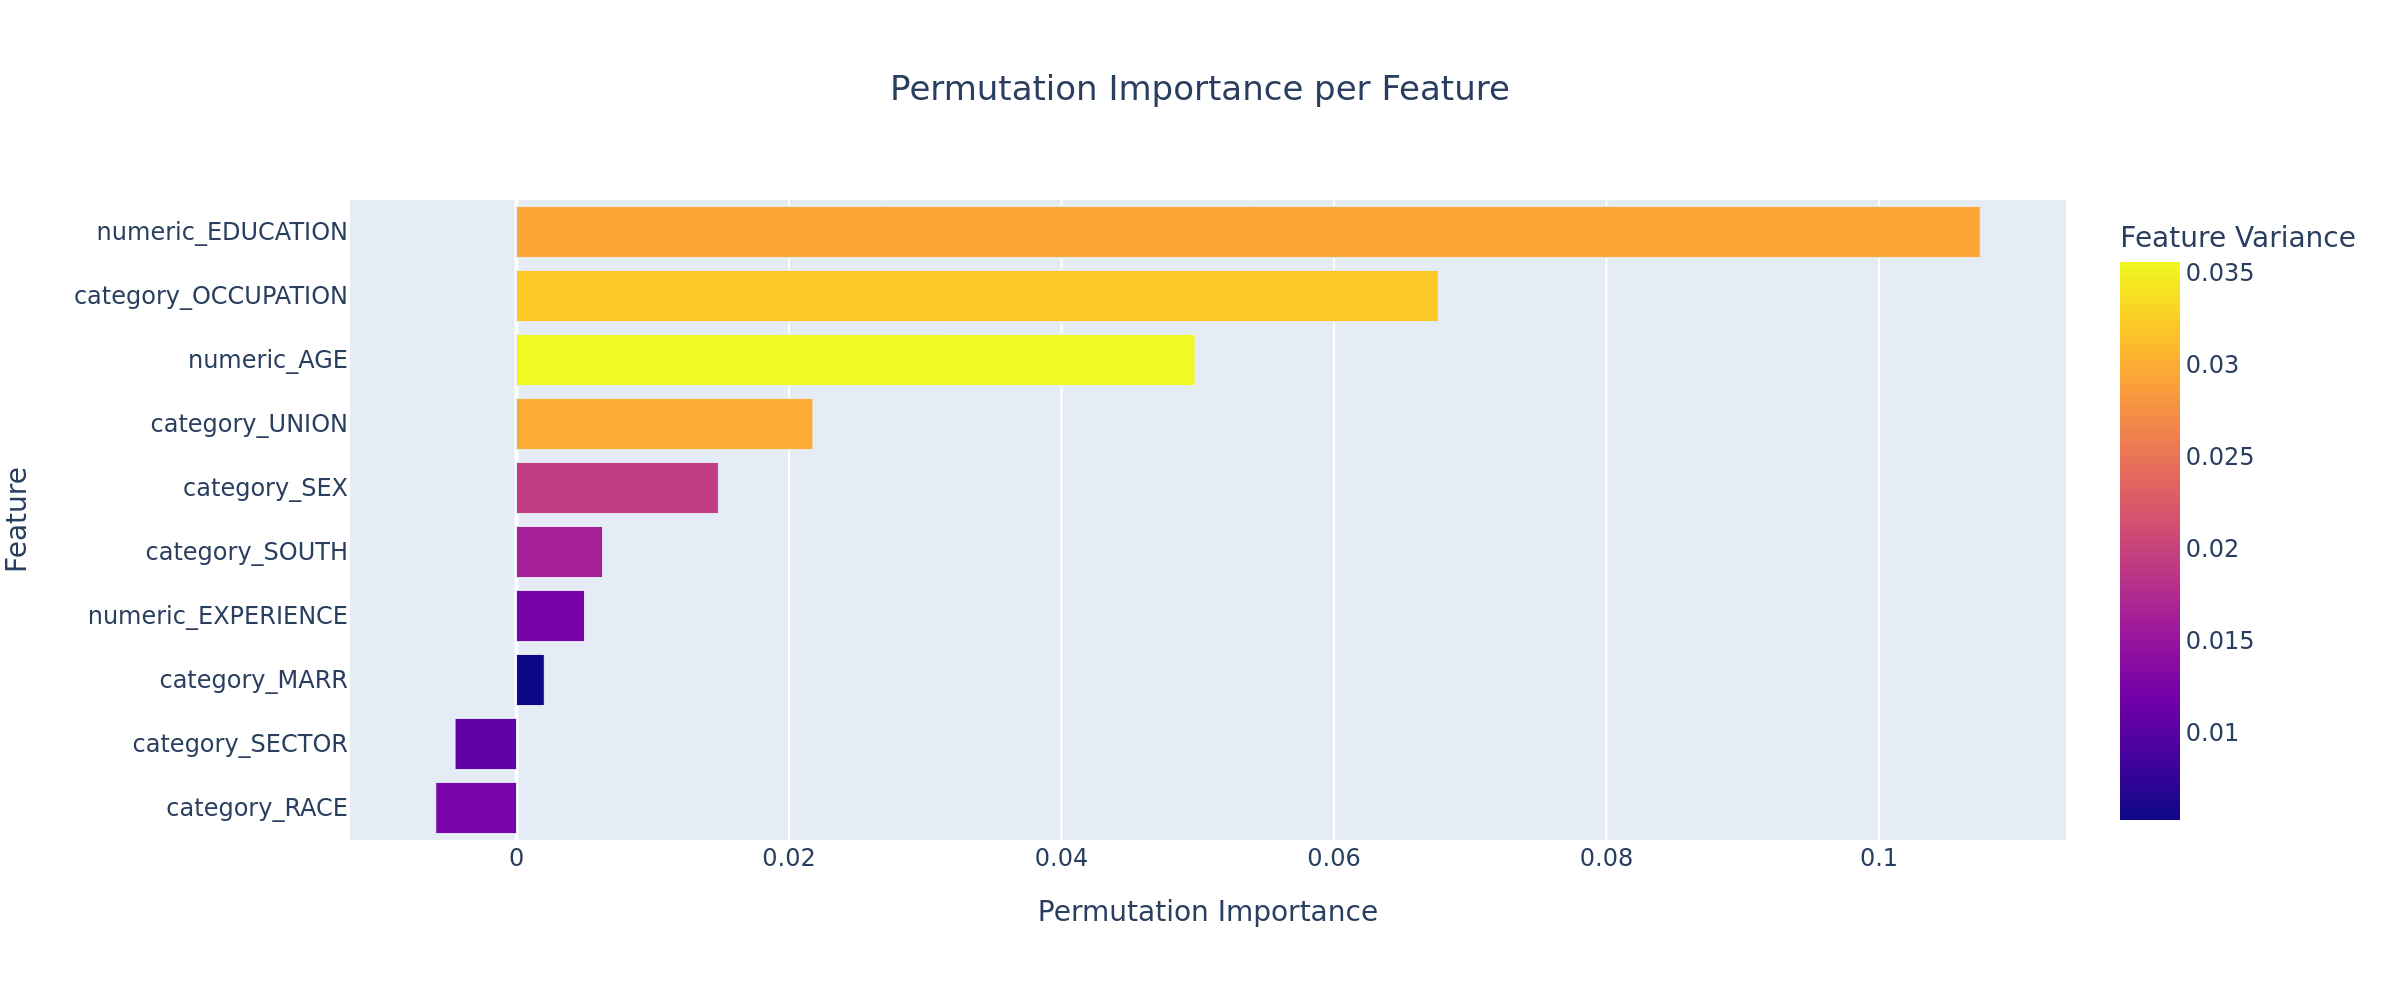

In [54]:
df_pi_reversed = df_pi[df_pi.columns[::-1]]

Image(
    px.bar(
        data_frame=df_pi_reversed.mean(),
        color=df_pi_reversed.std(),
        orientation="h",
        title="Permutation Importance per Feature",
        labels={
            "value": "Permutation Importance",
            "index": "Feature",
            "color": "Feature Variance",
        },
    )
    .update_layout(title_x=0.5)
    .to_image(format="png", width=1200, scale=2)
)

### With Seaborn

Text(0, 0.5, 'Feature')

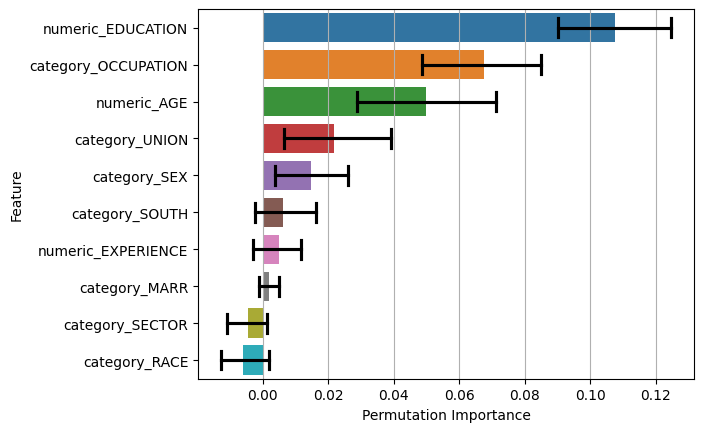

In [55]:
sns.barplot(
    df_pi,
    orient="h",
    err_kws={"color": "0.0"},
    capsize=0.5,
)

plt.xlabel("Permutation Importance")
plt.ylabel("Feature")

In [36]:
# sns.boxenplot(df_pi, orient="h")